# IMDB Merge

#### In this notebook, we merge the cmu corpus with the IMDB dataset and perform an exploratory data analysis on a joint data

### Loading CMU Corpus

In [5]:
CMU_PATH = "data/MovieSummaries"
IMDB_PATH = "data/imdb_data"

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from SPARQLWrapper import SPARQLWrapper, JSON
from src.utils.utils import assign_role_importance, country_female_ratio, role_man

metadata = pd.read_table(f"{CMU_PATH}/movie.metadata.tsv", header=None)

metadata.columns = [
    "Wikipedia movie ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages", 
    "Movie_countries",  
    "Movie_genres"     
]
metadata

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


We convert the different columns in a more readable format

In [8]:
import json
metadata["Movie_genres"] = metadata["Movie_genres"].apply(lambda x: list(json.loads(x).values()))
metadata["Movie_languages"] = metadata["Movie_languages"].apply(lambda x: list(json.loads(x).values()))
metadata["Movie_countries"] = metadata["Movie_countries"].apply(lambda x: list(json.loads(x).values()))
metadata

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


## Character metadata

### We also load the character metadata by CMU

In [11]:
characters = pd.read_table(f"{CMU_PATH}/character.metadata.tsv", header=None)

characters.columns = [
"Wikipedia movie ID",
"Freebase movie ID",
"Movie release date",
"Character name",
"Actor date of birth",
"Actor gender",
"Actor height (in meters)",
"Actor ethnicity (Freebase ID)",
"Actor name",
"Actor age at movie release",
"Freebase character/actor map ID",
"Freebase character ID",
"Freebase actor ID"
]

characters

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


### For the gender ratio analysis we won't use the CMU character dataset, but we clean it for future purposes

### We extract the relevant columns

In [14]:
characters =  characters[["Wikipedia movie ID", "Actor gender", "Actor name", "Actor age at movie release"]]

We group the actors such that we get a list that is easier to process and for later calculations (for example gender ratios)

In [16]:
characters = characters.groupby("Wikipedia movie ID").agg({
    "Actor gender": list, 
    "Actor name": list,
    "Actor age at movie release": list,
}).reset_index()
characters

,Wikipedia movie ID,Actor gender,Actor name,Actor age at movie release
0,330,"[F, F, F, F]","[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...","[54.0, 29.0, 51.0, 60.0]"
1,3217,"[M, M, M, M, M, F, F, F, M, M, M, nan, M, M]","[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...","[26.0, 36.0, 34.0, 34.0, 26.0, 28.0, 27.0, 35...."
2,3333,"[F, M, F, M, M, F, M, M, M, M, F, F, F, M]","[Lillian Gish, Henry B. Walthall, Mae Marsh, S...","[nan, nan, nan, nan, nan, 11.0, nan, nan, nan,..."
3,3746,"[M, M, M, F, F, F, M, M, M, M, M, M, M, M, nan]","[William Sanderson, Harrison Ford, Rutger Haue...","[34.0, 39.0, 38.0, 22.0, 21.0, 36.0, 37.0, 37...."
4,3837,"[M, M, M, M, M, M, M, M, M, F, M, M, M, M, F, ...","[Jack Starrett, Slim Pickens, Dave Sharpe, Lia...","[37.0, 54.0, 64.0, 57.0, 38.0, 40.0, 43.0, 35...."
...,...,...,...,...
64325,37373877,"[F, F, F, M, M, nan, M]","[Gabrielle Anwar, Traci Lords, Dina Meyer, Geo...","[36.0, 38.0, 37.0, 41.0, 43.0, nan, nan]"
64326,37476824,"[M, F, M, M, M, F, M, F, M, F]","[Zayed Khan, Raveena Tandon, Amitabh Bachchan,...","[30.0, 36.0, 68.0, 37.0, 59.0, 24.0, 40.0, 23...."
64327,37478048,"[M, M, F, M]","[Anupam Kher, Anil Kapoor, Sridevi Kapoor, Akk...","[40.0, 36.0, 32.0, 36.0]"
64328,37492363,"[nan, nan, nan]","[Molly Cera, Taylor Marie Milton, Spencer Jenk...","[nan, nan, nan]"


We check if all actors have a corresponding gender value. We verify that each actor has a gender prescribed

In [18]:
characters['len_match'] = characters.apply(lambda row: len(row['Actor name']) == len(row['Actor gender']), axis=1)
mismatch_rows = characters[characters['len_match'] == False]
mismatch_rows

,Wikipedia movie ID,Actor gender,Actor name,Actor age at movie release,len_match


We merge the two datasets to obtain a complete CMU corpus data with both movies and actors (for now we won't use it, it's for future purposes)

In [20]:
metadata_CMU = pd.merge(metadata, characters, on="Wikipedia movie ID", how="inner")
metadata_CMU

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor gender,Actor name,Actor age at movie release,len_match
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Wanda De Jesus, Natasha Henstridge, Ice Cube,...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, nan...",True
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]","[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]","[Allen Cutler, Alice Barrett, Rod Britt, Hildy...","[nan, 43.0, nan, nan, 50.0, 55.0, 40.0, 35.0, ...",True
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]","[M, F, M, F]","[Frank Krog, Kristin Kajander, Vidar Sandem, A...","[33.0, 28.0, 40.0, 30.0]",True
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...","[M, F]","[David Keith, Cathy Moriarty]","[32.0, 26.0]",True
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"[F, M, M]","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis...","[32.0, 32.0, 35.0]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64325,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]","[F, M, F, M, M, nan, F, M, nan, F, M, M, M]","[Kathleen Harrison, Raymond Huntley, Linden Tr...","[nan, 37.0, 27.0, 34.0, 40.0, nan, 22.0, nan, ...",True
64326,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]","[M, F, M, M, M, M, nan, nan, nan, M]","[Andrei Panin, Araceli Guzman-Rico, Giovanni B...","[45.0, nan, nan, 49.0, nan, nan, nan, nan, nan...",True
64327,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]","[M, M]","[Rich Little, Herb Voland]","[33.0, 53.0]",True
64328,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...","[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]","[Isshin Chiba, Tsutomu Takayama, 笠原弘子, Yumi Tō...","[23.0, 22.0, 22.0, 25.0, 52.0, nan, 32.0, 32.0...",True


<h1>Now we will be loading the datasets from IMDB</h1>

<h4> These datasets contain more information about the movies, including leading roles in the movies used for gender ratio analysis </h4>

### Here we load title.basics.tsv with IMDB movies id and titles of the movies

In [24]:
imdb_titles = pd.read_csv(f"{IMDB_PATH}/title.basics.tsv", sep="\t")

C:\Users\USER\AppData\Local\Temp\ipykernel_23480\2400539453.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles = pd.read_csv(f"{IMDB_PATH}/title.basics.tsv", sep="\t")


In [25]:
imdb_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


We drop all the rows that do not describe movies

In [27]:
imdb_titles = imdb_titles[imdb_titles["titleType"] == 'movie']

We verify we have only one title type

In [29]:
imdb_titles.nunique()

tconst            697071
titleType              1
primaryTitle      599769
originalTitle     613424
isAdult                4
startYear            138
endYear                1
runtimeMinutes       519
genres              1491
dtype: int64

We can see that endYear is not really useful (only 1 value). We decide to drop it and only use startYear as reference for later.

In [31]:
imdb_titles = imdb_titles.drop(columns=["endYear"])

We convert start year into integers so we can easily plot them afterwards. We also convert NaNs to 0 so that we can avoid errors later. They will be discarded as we start our analysis after a certain year, but they can be filled with CMU data or another dataset for milestone 3.

In [33]:
imdb_titles["startYear"] = pd.to_numeric(imdb_titles["startYear"], errors="coerce")
imdb_titles["startYear"] = imdb_titles["startYear"].fillna(0).astype(int)
imdb_titles = imdb_titles.rename(columns = {"startYear":"Movie_release_date"})

### Here we load title.principals.tsv with IMDB movies and staff's id (people already ranked by importance), including actors, directors etc

In [35]:
imdb_actors = pd.read_csv(f"{IMDB_PATH}/title.principals.tsv", sep="\t", engine = "pyarrow")

In [36]:
imdb_actors

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0005690,producer,producer,\N
3,tt0000001,4,nm0374658,cinematographer,director of photography,\N
4,tt0000002,1,nm0721526,director,\N,\N
...,...,...,...,...,...,...
89094680,tt9916880,17,nm0996406,director,principal director,\N
89094681,tt9916880,18,nm1482639,writer,\N,\N
89094682,tt9916880,19,nm2586970,writer,books,\N
89094683,tt9916880,20,nm1594058,producer,producer,\N


We drop all movie staff that is not an actor or actress

In [38]:
imdb_actors = imdb_actors.drop(
    imdb_actors[~imdb_actors["category"].isin(["actor", "actress"])].index
)

We drop duplicate actors (that appear in the same movie more than once)

In [40]:
imdb_actors = imdb_actors.drop_duplicates(subset=['tconst', 'nconst'])

We only want to keep actors which are in our movies' dataset

In [42]:
imdb_actors = imdb_actors[imdb_actors['tconst'].isin(imdb_titles['tconst'])]

### Here we load name.basics.tsv with IMDB actors' id and their characteristics like name, birth year etc

In [44]:
imdb_actors_names = pd.read_csv(f"{IMDB_PATH}/name.basics.tsv", sep="\t", engine = "pyarrow")

In [45]:
imdb_actors_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0050419,tt0072308,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
...,...,...,...,...,...,...
13944213,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
13944214,nm9993716,Essias Loberg,\N,\N,\N,\N
13944215,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13944216,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


### We assign actors' ids with their other information by merging imdb_actors and imdb_actors_names

In [47]:
imdb_actors = imdb_actors.merge(imdb_actors_names[['nconst', 'primaryName']], on='nconst', how='left')

Mapping the gender for readability, renaming the column's name and dropping unused columns

In [49]:
imdb_actors.category = imdb_actors.category.map({"actor": "M", "actress": "F"})

In [50]:
imdb_actors = imdb_actors.rename(columns={"category":"gender"})

In [51]:
imdb_actors_clean = imdb_actors.drop(columns = ["ordering", "job", "characters"])
imdb_actors_clean

,tconst,nconst,gender,primaryName
0,tt0000009,nm0063086,F,Blanche Bayliss
1,tt0000009,nm0183823,M,William Courtenay
2,tt0000009,nm1309758,M,Chauncey Depew
3,tt0000502,nm0215752,M,Antonio del Pozo
4,tt0000502,nm0252720,M,El Mochuelo
...,...,...,...,...
3796254,tt9916730,nm4852679,M,Bhushan Pradhan
3796255,tt9916730,nm9050497,M,Pranav Raorane
3796256,tt9916730,nm7365126,F,Aarti Solanki
3796257,tt9916730,nm1576284,F,Amruta Subhash


We group the actors such that we get a list that is easier to process and for later calculations (for example gender ratios)

In [53]:
aggregate_actors = imdb_actors_clean.groupby("tconst").agg({
    "gender": list, 
    "primaryName": list,
}).reset_index()
aggregate_actors

,tconst,gender,primaryName
0,tt0000009,"[F, M, M]","[Blanche Bayliss, William Courtenay, Chauncey ..."
1,tt0000502,"[M, M]","[Antonio del Pozo, El Mochuelo]"
2,tt0000574,"[F, M, M, M, M, F, M, M, M, M]","[Elizabeth Tait, John Tait, Nicholas Brierley,..."
3,tt0000591,"[M, M, F, F]","[Georges Wague, Henri Gouget, Christiane Mande..."
4,tt0000615,"[M, M, M, M, M, F]","[Jim Gerald, George Merriman, Lance Vane, Will..."
...,...,...,...
506218,tt9916428,"[M, M, M, M, F, M, M, M, M, M]","[Kenan Heppe, Wang Peng Kai, Valery Gadreau, X..."
506219,tt9916538,"[F, F, M, F, M, M, M, M, F, M]","[Lala Karmela, Cut Mini Theo, Sahil Shah, Ria ..."
506220,tt9916622,[M],[Oldair Soares Ammom]
506221,tt9916706,"[M, M, M, F, F, M, M, M, F, M]","[Makarand Anaspure, Anvay Bendre, Prakash Dhot..."


We merge the two imdb datasets on the tconst (imdb unique id)

In [55]:
imdb_titles = imdb_titles.merge(aggregate_actors, on = "tconst", how = "inner")

In [56]:
imdb_titles = imdb_titles.rename(columns={"primaryName":"actors"})

We double check if all actors' lists have their corresponding gender's lists and if their lengths are the same

In [58]:
imdb_titles['gender'].apply(type).value_counts()

gender
<class 'list'>    506223
Name: count, dtype: int64

In [59]:
imdb_titles['len_match_imdb'] = imdb_titles.apply(
    lambda row: len(row['actors']) == len(row['gender']), axis=1
)
mismatch_rows  = imdb_titles[imdb_titles['len_match_imdb'] == False]
mismatch_rows

,tconst,titleType,primaryTitle,originalTitle,isAdult,Movie_release_date,runtimeMinutes,genres,gender,actors,len_match_imdb


Here we handle the release date (to only have the year)

In [61]:
metadata['Movie_release_date'] = pd.to_numeric(metadata['Movie_release_date'].str[:4], errors='coerce')
metadata['Movie_release_date'] = metadata['Movie_release_date'].fillna(0).astype(int)
metadata.loc[metadata['Movie_release_date']==1010,'Movie_release_date'] = 2010
metadata

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,NaN,120.0,[English Language],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


## Merging the two datasets

In this code, we read the wikidata to have a mapping between IMDB ID and Freebase ID. This will be useful for us to merge the two datasets. 

In [64]:
!pip install SPARQLWrapper -q

In [65]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

sparql.setQuery("""
    SELECT ?imdbID ?freebaseID WHERE {
      ?movie wdt:P31 wd:Q11424.                # The movie is a film
      ?movie wdt:P345 ?imdbID.                 # The movie has an IMDb ID
      ?movie wdt:P646 ?freebaseID.             # The movie has a Freebase ID
    }
""")

sparql.setReturnFormat(JSON)

results = sparql.query().convert()

data = []

for result in results["results"]["bindings"]:
    imdb_id = result["imdbID"]["value"]
    freebase_id = result["freebaseID"]["value"]
    data.append([imdb_id, freebase_id])

tconst_freebase_df = pd.DataFrame(data, columns=["tconst", "Freebase_movie_ID"])

tconst_freebase_df

,tconst,Freebase_movie_ID
0,tt0120685,/m/04fzfj
1,tt0101309,/m/0gks6hv
2,tt1361843,/m/07kdtt1
3,tt1772250,/m/0nfwcsx
4,tt0105764,/m/03mzg2
...,...,...
106109,tt0348062,/m/0crtsyc
106110,tt1772941,/m/012bnmkd
106111,tt0283989,/m/0crrv_x
106112,tt4241338,/m/0129bw1s


In [66]:
metadata.head(1)

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."


In [67]:
imdb_titles.head(1)

,tconst,titleType,primaryTitle,originalTitle,isAdult,Movie_release_date,runtimeMinutes,genres,gender,actors,len_match_imdb
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,45,Romance,"[F, M, M]","[Blanche Bayliss, William Courtenay, Chauncey ...",True


We drop unused information

In [69]:
imdb_titles.drop(['titleType', 'primaryTitle', 'originalTitle', 'len_match_imdb', 'runtimeMinutes'], axis=1, inplace=True)

We first add the tconsts (IMDB ids) to our CMU metadata

In [71]:
first_merge_df = pd.merge(metadata, tconst_freebase_df, on=["Freebase_movie_ID"], how='inner')
first_merge_df

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],tt0083949
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852
...,...,...,...,...,...,...,...,...,...,...
63337,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660
63338,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",tt0459759
63339,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259
63340,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411


We then proceed to merge the IMDB dataset with our metadata using the tconst variable

In [73]:
second_merge_df = pd.merge(first_merge_df, imdb_titles, on=["tconst"], how='inner')
second_merge_df

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,isAdult,Movie_release_date_y,genres,gender,actors
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,0,2001,"Action,Horror,Sci-Fi","[F, M, F, M, F, F, M, F, M, M]","[Natasha Henstridge, Ice Cube, Pam Grier, Jaso..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,0,1988,"Crime,Drama","[M, F, F, M, M, M, F, M, M, F]","[Frank Krog, Kristin Kajander, Anne Krigsvoll,..."
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,0,1987,"Horror,Mystery,Thriller","[M, F, M, M, M, F, F, M, M, M]","[David Keith, Cathy Moriarty, Alan Rosenberg, ..."
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,0,1983,Drama,"[F, M, M, F, M, M, F, M, M, F]","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis..."
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,0,1938,"Drama,Music,Musical","[M, F, M, F, M, M, F, M, M, M]","[Tyrone Power, Alice Faye, Don Ameche, Ethel M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57109,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,0,1941,"Comedy,Horror","[M, M, F, M, F, M, F, M, M, M]","[Arthur Askey, Richard Murdoch, Kathleen Harri..."
57110,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",tt0459759,0,2007,"Action,Crime,Drama","[F, M, M, M, M, F, M, M, M, M]","[Elena Panova, Andrey Panin, Victor Herminio L..."
57111,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,0,2011,"Biography,Documentary,Drama","[M, M, M, M]","[James Quinn McDonagh, Paddy Quinn McDonagh, M..."
57112,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411,0,1972,Comedy,"[M, M, F, M, M, M, F, M, M, M]","[Rich Little, Herb Voland, Diahn Williams, Bru..."


We check for missing values

In [75]:
second_merge_df.isna().sum()

Wikipedia movie ID              0
Freebase_movie_ID               0
Movie_name                      0
Movie_release_date_x            0
Movie_box_office_revenue    49170
Movie_runtime               12022
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
tconst                          0
isAdult                         0
Movie_release_date_y            0
genres                          0
gender                          0
actors                          0
dtype: int64

Here we extract 3 most important characters from the movies

We apply the function and create a copy of merged dataset

In [78]:
merged_df = assign_role_importance(second_merge_df)
copy_merged_df = merged_df.copy()
merged_df

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,...,Movie_release_date_y,genres,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,...,2001,"Action,Horror,Sci-Fi","[F, M, F, M, F, F, M, F, M, M]","[Natasha Henstridge, Ice Cube, Pam Grier, Jaso...",Natasha Henstridge,Ice Cube,Pam Grier,F,M,F
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,...,1988,"Crime,Drama","[M, F, F, M, M, M, F, M, M, F]","[Frank Krog, Kristin Kajander, Anne Krigsvoll,...",Frank Krog,Kristin Kajander,Anne Krigsvoll,M,F,F
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,...,1987,"Horror,Mystery,Thriller","[M, F, M, M, M, F, F, M, M, M]","[David Keith, Cathy Moriarty, Alan Rosenberg, ...",David Keith,Cathy Moriarty,Alan Rosenberg,M,F,M
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,...,1983,Drama,"[F, M, M, F, M, M, F, M, M, F]","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis...",Gudrun Landgrebe,Mathieu Carrière,Hanns Zischler,F,M,M
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,...,1938,"Drama,Music,Musical","[M, F, M, F, M, M, F, M, M, M]","[Tyrone Power, Alice Faye, Don Ameche, Ethel M...",Tyrone Power,Alice Faye,Don Ameche,M,F,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57109,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,...,1941,"Comedy,Horror","[M, M, F, M, F, M, F, M, M, M]","[Arthur Askey, Richard Murdoch, Kathleen Harri...",Arthur Askey,Richard Murdoch,Kathleen Harrison,M,M,F
57110,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",tt0459759,...,2007,"Action,Crime,Drama","[F, M, M, M, M, F, M, M, M, M]","[Elena Panova, Andrey Panin, Victor Herminio L...",Elena Panova,Andrey Panin,Victor Herminio Lopez,F,M,M
57111,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,...,2011,"Biography,Documentary,Drama","[M, M, M, M]","[James Quinn McDonagh, Paddy Quinn McDonagh, M...",James Quinn McDonagh,Paddy Quinn McDonagh,Michael Quinn McDonagh,M,M,M
57112,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411,...,1972,Comedy,"[M, M, F, M, M, M, F, M, M, M]","[Rich Little, Herb Voland, Diahn Williams, Bru...",Rich Little,Herb Voland,Diahn Williams,M,M,F


We create variable which indicates how many male and female most important actors were in the movie

In [80]:
copy_merged_df['F'] = (copy_merged_df[['first_role_gender', 'second_role_gender', 'third_role_gender']] == 'F').sum(axis=1)
copy_merged_df['M'] = (copy_merged_df[['first_role_gender', 'second_role_gender', 'third_role_gender']] == 'M').sum(axis=1)
copy_merged_df

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,...,"[F, M, F, M, F, F, M, F, M, M]","[Natasha Henstridge, Ice Cube, Pam Grier, Jaso...",Natasha Henstridge,Ice Cube,Pam Grier,F,M,F,2,1
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,...,"[M, F, F, M, M, M, F, M, M, F]","[Frank Krog, Kristin Kajander, Anne Krigsvoll,...",Frank Krog,Kristin Kajander,Anne Krigsvoll,M,F,F,2,1
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,...,"[M, F, M, M, M, F, F, M, M, M]","[David Keith, Cathy Moriarty, Alan Rosenberg, ...",David Keith,Cathy Moriarty,Alan Rosenberg,M,F,M,1,2
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,...,"[F, M, M, F, M, M, F, M, M, F]","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis...",Gudrun Landgrebe,Mathieu Carrière,Hanns Zischler,F,M,M,1,2
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,...,"[M, F, M, F, M, M, F, M, M, M]","[Tyrone Power, Alice Faye, Don Ameche, Ethel M...",Tyrone Power,Alice Faye,Don Ameche,M,F,M,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57109,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,...,"[M, M, F, M, F, M, F, M, M, M]","[Arthur Askey, Richard Murdoch, Kathleen Harri...",Arthur Askey,Richard Murdoch,Kathleen Harrison,M,M,F,1,2
57110,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",tt0459759,...,"[F, M, M, M, M, F, M, M, M, M]","[Elena Panova, Andrey Panin, Victor Herminio L...",Elena Panova,Andrey Panin,Victor Herminio Lopez,F,M,M,1,2
57111,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,...,"[M, M, M, M]","[James Quinn McDonagh, Paddy Quinn McDonagh, M...",James Quinn McDonagh,Paddy Quinn McDonagh,Michael Quinn McDonagh,M,M,M,0,3
57112,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411,...,"[M, M, F, M, M, M, F, M, M, M]","[Rich Little, Herb Voland, Diahn Williams, Bru...",Rich Little,Herb Voland,Diahn Williams,M,M,F,1,2


<h1> Exploratory Data Analysis </h1>

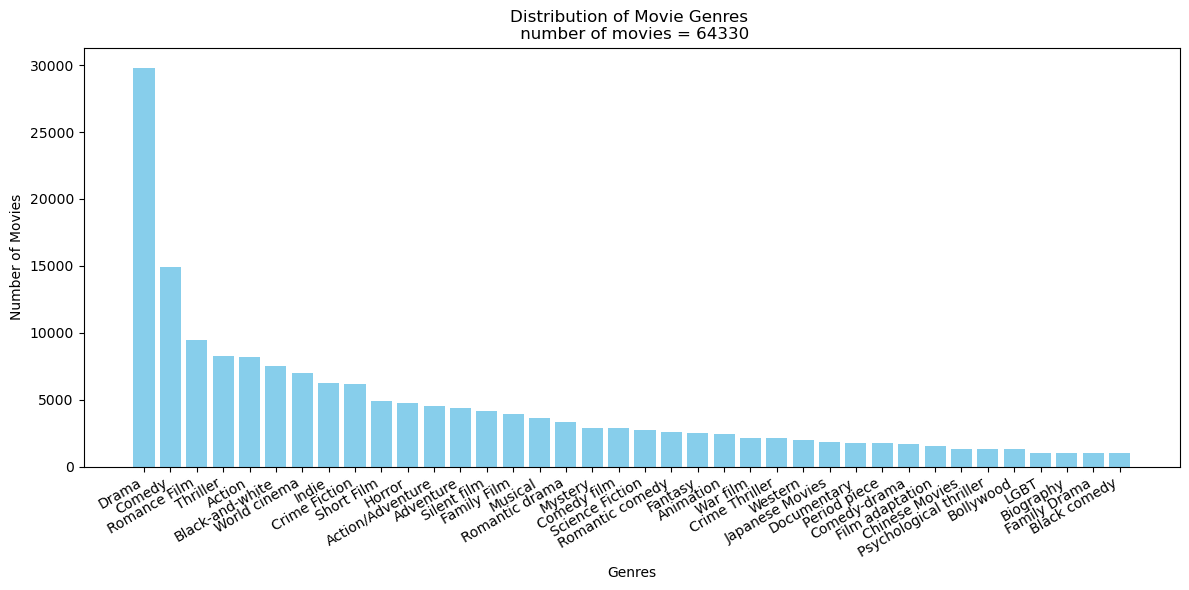

In [82]:
from collections import Counter
all_genres = [genre for sublist in metadata_CMU['Movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_counts = {genre: count for genre, count in genre_counts.items() if count >= 1000}
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(genre_counts.keys(), genre_counts.values(), color='skyblue')
plt.title(f'Distribution of Movie Genres \n number of movies = {len(metadata_CMU)}')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

<h3>Now we check ratio evolution throughout years (and exclude nan values previously assigned to 0)</h3>

In [84]:
gender_year_df = copy_merged_df[copy_merged_df["Movie_release_date_x"] > 0]

Here we extract important columns and rows, create an overall sum of important characters for a movie

In [86]:
gender_year_df = gender_year_df[["Movie_release_date_x", "F", "M"]]

In [87]:
gender_year_df.loc[:,"sum"] = gender_year_df["F"] + gender_year_df["M"]

Verification if nothing is missing

In [89]:
gender_year_df.isna().sum()

Movie_release_date_x    0
F                       0
M                       0
sum                     0
dtype: int64

Here we aggregate with respect to the year of release to analyse female representation towards the years

In [91]:
gender_year_sum_df = gender_year_df.groupby("Movie_release_date_x").agg({
    "F": sum, 
    "M": sum,
    "sum": sum,
}).reset_index()
gender_year_sum_df

C:\Users\USER\AppData\Local\Temp\ipykernel_23480\2630017406.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  gender_year_sum_df = gender_year_df.groupby("Movie_release_date_x").agg({


,Movie_release_date_x,F,M,sum
0,1903,1,1,2
1,1907,1,5,6
2,1908,0,3,3
3,1910,4,9,13
4,1911,16,45,61
...,...,...,...,...
105,2012,980,1689,2669
106,2013,116,243,359
107,2014,15,15,30
108,2015,3,3,6


To avoid division by 0

In [93]:
gender_year_sum_df = gender_year_sum_df[gender_year_sum_df["sum"] > 0]
gender_year_sum_df

,Movie_release_date_x,F,M,sum
0,1903,1,1,2
1,1907,1,5,6
2,1908,0,3,3
3,1910,4,9,13
4,1911,16,45,61
...,...,...,...,...
105,2012,980,1689,2669
106,2013,116,243,359
107,2014,15,15,30
108,2015,3,3,6


Calculating gender ratios and saving a df for plotting

In [95]:
gender_year_sum_df.loc[:, "Female_ratio"] = gender_year_sum_df["F"]/gender_year_sum_df["sum"]
gender_year_sum_df = gender_year_sum_df[["Movie_release_date_x", "Female_ratio"]]

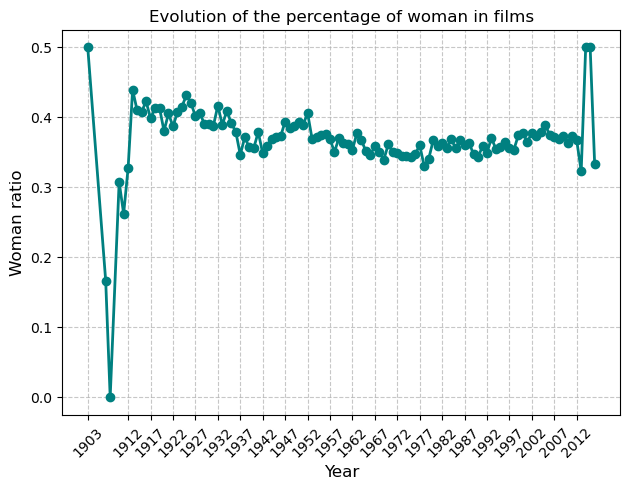

In [96]:
plt.plot(gender_year_sum_df['Movie_release_date_x'], gender_year_sum_df['Female_ratio'], color='teal', marker='o', linestyle='-', linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Woman ratio', fontsize=12)
plt.xticks(gender_year_sum_df['Movie_release_date_x'][::5], rotation=45)  # Show every 5th year
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.title("Evolution of the percentage of woman in films")

plt.show()

<h3>Analysis with some specific countries</h3>

We check the distribution of the movies which are unique for each country

In [99]:
all_countries = set(country for sublist in merged_df["Movie_countries"] for country in sublist)
country_dict = {}
for country in all_countries:
    country_dict[country] = metadata[metadata["Movie_countries"].apply(lambda x: country in x and len(x) == 1)].shape[0]
# country_dict
sorted_by_values = dict(sorted(country_dict.items(), key=lambda item: item[1], reverse=True))
sorted_by_values

{'United States of America': 30300,
 'India': 8240,
 'United Kingdom': 5343,
 'Japan': 2242,
 'France': 1853,
 'Italy': 1730,
 'Canada': 1342,
 'Argentina': 1266,
 'Hong Kong': 850,
 'South Korea': 788,
 'Germany': 778,
 'Mexico': 685,
 'Australia': 631,
 'Netherlands': 606,
 'Spain': 477,
 'Denmark': 418,
 'Sweden': 415,
 'Soviet Union': 404,
 'Philippines': 344,
 'China': 307,
 'Czechoslovakia': 297,
 'German Democratic Republic': 286,
 'Poland': 284,
 'Norway': 228,
 'Hungary': 221,
 'Brazil': 214,
 'West Germany': 210,
 'Yugoslavia': 193,
 'Thailand': 170,
 'Turkey': 165,
 'Iran': 163,
 'Pakistan': 162,
 'Finland': 158,
 'Russia': 153,
 'Greece': 135,
 'Israel': 132,
 'Egypt': 124,
 'Czech Republic': 111,
 'Indonesia': 108,
 'Croatia': 106,
 'Austria': 102,
 'South Africa': 91,
 'New Zealand': 86,
 'Malaysia': 85,
 'Sri Lanka': 82,
 'Ireland': 79,
 'Portugal': 75,
 'Belgium': 73,
 'Romania': 65,
 'Cambodia': 65,
 'Bulgaria': 63,
 'Bangladesh': 59,
 'Singapore': 57,
 'Taiwan': 50,
 

We plot distribution of some of the most impactful countres for movie industry

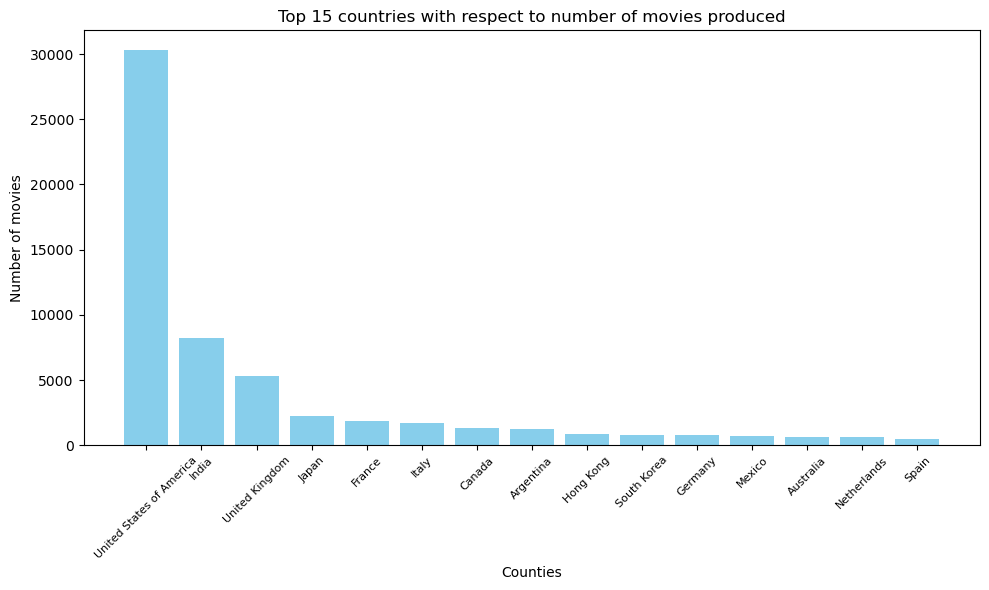

In [101]:
plt.figure(figsize=(10, 6))
plt.bar(list(sorted_by_values.keys())[:15], list(sorted_by_values.values())[:15], color='skyblue')

plt.title("Top 15 countries with respect to number of movies produced")
plt.xlabel("Counties")
plt.ylabel("Number of movies")

plt.xticks(rotation=45, fontsize=8)

plt.tight_layout()
plt.show()

We plot female ratio for 12 countries with most of the movies

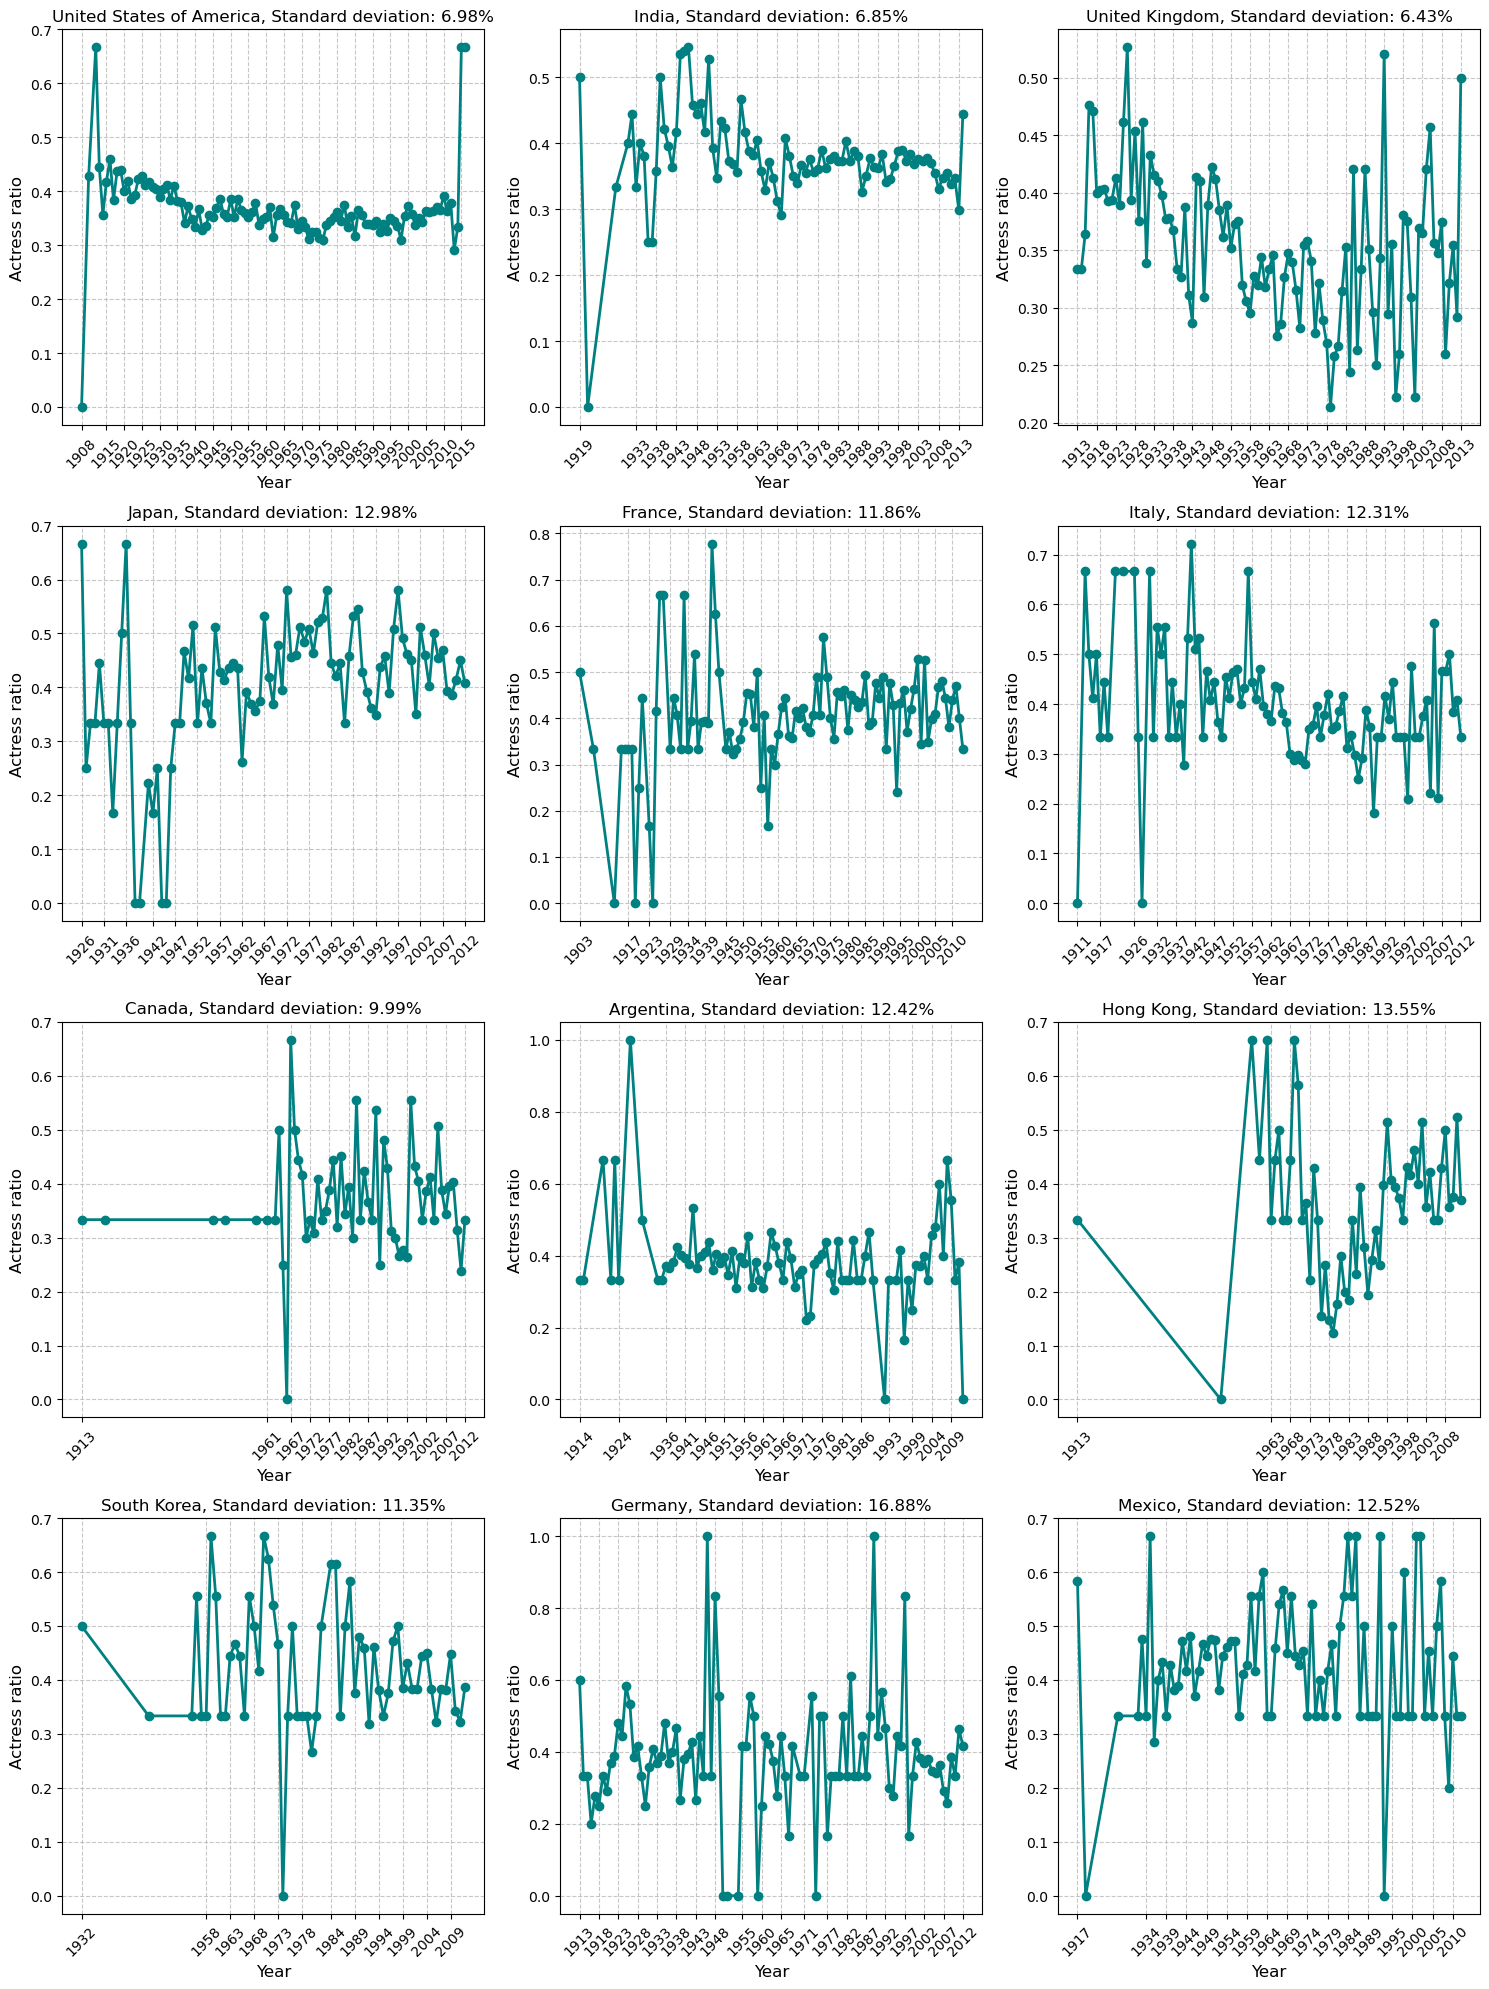

In [103]:
num_countries = 12
countries = list(sorted_by_values.keys())[:num_countries]
cols = 3  
rows = (num_countries // cols) + (num_countries % cols > 0)  

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  
for i, country in enumerate(countries):
    plt.sca(axes[i]) 
    std = country_female_ratio(copy_merged_df, country) 
    axes[i].set_title(f"{country}, Standard deviation: {std*100:.2f}%")  

plt.tight_layout()
plt.show()

We see that most of the countries have less actress than actors in the film cast. However, some countires like Japan or Mexico have higher actress ratio. 

These graphs could be improved for milestone 3: we could do analysis of continents/regions of the world, we could look not for single years, but for example decades/5 years periods

We now look at ratio evolution between film genre which are highly non-inclusive (films where women are highly not included (like war films) or where they are more present like erotic films)

In [107]:
erotic_genres = ['Sex comedy','Erotica','Erotic thriller','Pornographic movie','Adult','Erotic Drama','Sexploitation','Softcore Porn','Gay pornography','Hardcore pornography','Pornography']
erotic_movies = metadata_CMU[metadata_CMU["Movie_genres"].apply(lambda x: any(genre in erotic_genres for genre in x))]["Movie_name"].values
war_genres = ["War film"]
war_movies = metadata_CMU[metadata_CMU["Movie_genres"].apply(lambda x: any(genre in war_genres for genre in x))]["Movie_name"].values

religious_genres = ["Religious Film"]
religious_movies = metadata_CMU[metadata_CMU["Movie_genres"].apply(lambda x: any(genre in religious_genres for genre in x))]["Movie_name"].values

romantic_genres = ["Romantic drama", "Romantic comedy, Romance Film"]
romantic_movies = metadata_CMU[metadata_CMU["Movie_genres"].apply(lambda x: any(genre in romantic_genres for genre in x))]["Movie_name"].values


In [108]:
df_imdb = merged_df.copy()

We count the number of women/men actor as first /second /third role

In [110]:
df_imdb["Binary_1st"] = df_imdb["first_role_gender"].apply(lambda x: role_man(x))
df_imdb["Binary_2nd"] = df_imdb["second_role_gender"].apply(lambda x: role_man(x))
df_imdb["Binary_3rd"] = df_imdb["third_role_gender"].apply(lambda x: role_man(x))
df_imdb["Ratio"] = df_imdb["gender"].apply(lambda x: Counter(x)["M"]/(Counter(x)["F"]+Counter(x)["M"] if x != '[]' else -1))


Text(0.5, 0, 'Movie release date')

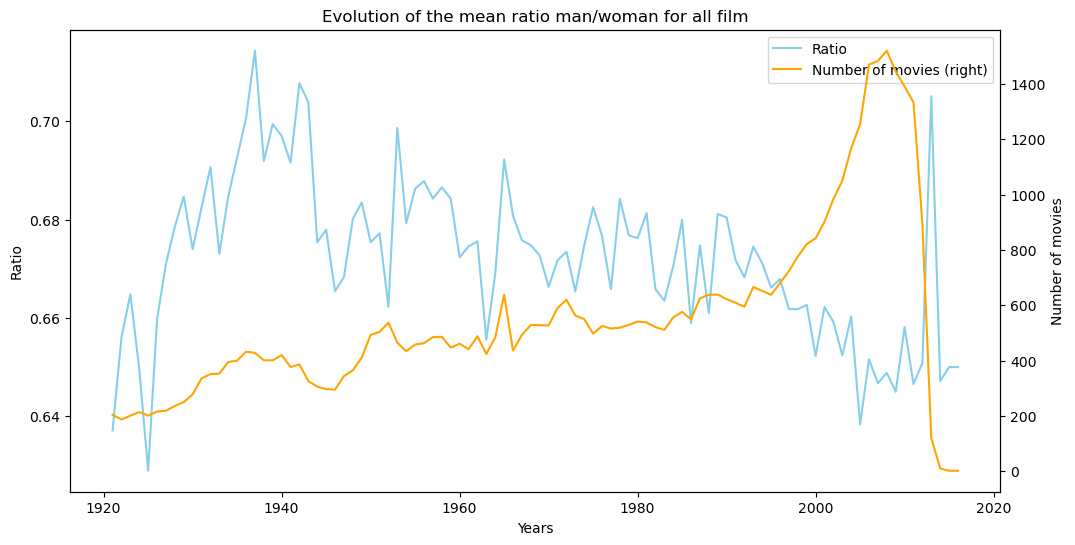

In [111]:
plt.figure(figsize=(12, 6))
df_imdb[(df_imdb["Movie_release_date_x"] >1920) & (df_imdb["Ratio"] >=0)].groupby("Movie_release_date_x")["Ratio"].mean().plot(kind='line', color='skyblue', ylabel='Ratio', legend=True, label='Ratio')

df_imdb[df_imdb["Movie_release_date_x"] >1920].groupby("Movie_release_date_x")["Movie_name"].count().plot(kind='line', color='orange', 
                                                                                                              secondary_y=True,
                                                                                                              ylabel='Number of movies', legend=True, label='Number of movies', xlabel="Years")


plt.title("Evolution of the mean ratio man/woman for all film")

plt.xlabel("Movie release date")

The percentage of man in film decreases after the year 2000. Hence there are more woman generally in films. However, the number of films before 2000 was much lower, hence the variability is higher, and thus the results are less precise. 

Now we can look at the distribution of 1st role actors in movies

In [114]:
print(f'Ratio of man/woman for 1st role is : {df_imdb["Binary_1st"].sum()/len(df_imdb)}')

Ratio of man/woman for 1st role is : 0.7154287915397276


Text(0.5, 1.03, 'Mean Ratio of man/woman for different roles in different film genres (Decade Averaged)')

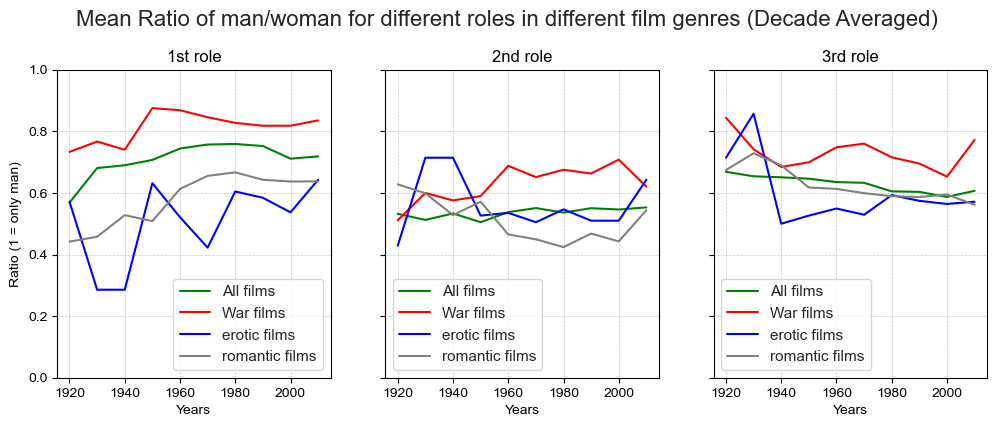

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
sns.set(style="whitegrid")
dc = 10
df_imdb[(df_imdb["Movie_release_date_x"] > 1920)].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_1st"].mean().plot(kind='line', color='green', legend=True, label='All films', ax=ax[0])
df_imdb[(df_imdb["Movie_release_date_x"] > 1920)].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_2nd"].mean().plot(kind='line', color='green', legend=True, label='All films', ax=ax[1])
df_imdb[(df_imdb["Movie_release_date_x"] > 1920)].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_3rd"].mean().plot(kind='line', color='green', legend=True, label='All films', ax=ax[2])

df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(war_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_1st"].mean().plot(kind='line', color='red', legend=True, label='War films', ax=ax[0])
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(erotic_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_1st"].mean().plot(kind='line', color='blue', legend=True, label='erotic films', ax=ax[0])
#df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(religious_movies))].groupby(df_imdb["Movie_release_date_x"] // 10 * 10)["Binary"].mean().plot(kind='line', color='gray', legend=True, label='religious films')
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(romantic_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_1st"].mean().plot(kind='line', color='gray', legend=True, label='romantic films', ax=ax[0])



df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(war_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_2nd"].mean().plot(kind='line', color='red', legend=True, label='War films', ax=ax[1])
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(erotic_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_2nd"].mean().plot(kind='line', color='blue', legend=True, label='erotic films', ax=ax[1])
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(romantic_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_2nd"].mean().plot(kind='line', color='gray', legend=True, label='romantic films', ax=ax[1])

df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(war_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_3rd"].mean().plot(kind='line', color='red', legend=True, label='War films', ax=ax[2])
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(erotic_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_3rd"].mean().plot(kind='line', color='blue', legend=True, label='erotic films', ax=ax[2])
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Movie_name"].isin(romantic_movies))].groupby(df_imdb["Movie_release_date_x"] // dc * dc)["Binary_3rd"].mean().plot(kind='line', color='gray', legend=True, label='romantic films', ax=ax[2])


ax[0].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax[1].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax[2].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

ax[0].set_title("1st role")
ax[1].set_title("2nd role")
ax[2].set_title("3rd role")

ax[0].set_ylabel("Ratio (1 = only man)")
ax[0].set_xlabel("Years")
ax[1].set_xlabel("Years")
ax[2].set_xlabel("Years")

ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])
ax[2].set_ylim([0, 1])


fig.suptitle("Mean Ratio of man/woman for different roles in different film genres (Decade Averaged)", fontsize=16, y=1.03)


For 1st role, we see that war films have a very low percentage of actress. This is not surprising as war films are generally about historical events where woman were not excluded. On the other hand, erotic films have a higher percentage of actress as 1st role. 
Generally, all films have a higher percentage of male actors as first role. 
The resutls are less evident when it comes to 2nd and third role. Globally speeking, the percentage of male actors in leading roles is higher than for actress. 

Now we wonder; do cast with high propertion of man have woman actor in first role ? 

Text(0, 0.5, 'Ratio of 1st role')

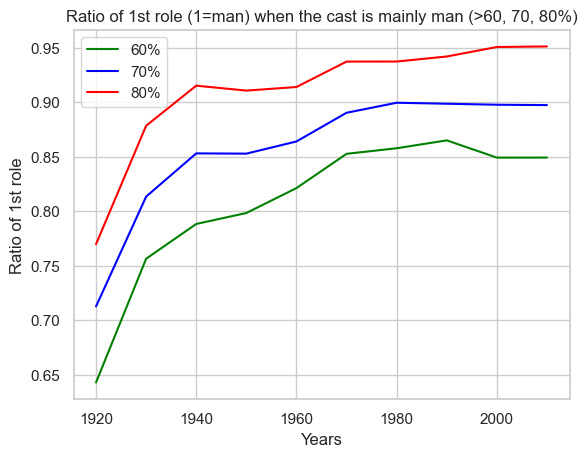

In [118]:
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Ratio"] >0.6)].groupby(df_imdb["Movie_release_date_x"] // 10 * 10)["Binary_1st"].mean().plot(kind='line', color='green', legend=True, label='60%')
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Ratio"] >0.7)].groupby(df_imdb["Movie_release_date_x"] // 10 * 10)["Binary_1st"].mean().plot(kind='line', color='blue', legend=True, label='70%')
df_imdb[(df_imdb["Movie_release_date_x"] > 1920) & (df_imdb["Ratio"] >0.8)].groupby(df_imdb["Movie_release_date_x"] // 10 * 10)["Binary_1st"].mean().plot(kind='line', color='red', legend=True, label='80%')
plt.title("Ratio of 1st role (1=man) when the cast is mainly man (>60, 70, 80%)")
plt.xlabel("Years")
plt.ylabel('Ratio of 1st role')

How to read this graph : in 1940, when the cast in more than 70% man, then there is 85% of first role which are man

We see that when the cast is mostly composed of man, the first role is mainly attributed to male actors. 